# Qiita ~ A/Bテストは無理だと言われたあなたへ ~

In [1]:
import numpy as np
import pandas as pd

from pandas import DataFrame
from plotly.graph_objs import Bar, Figure, Layout
from plotly.offline import iplot, plot

from sklearn.metrics import roc_auc_score
import statsmodels.api as sm

### CM Data

In [2]:
# データの読み込み
df = pd.read_csv('https://github.com/iwanami-datascience/vol3/raw/master/kato%26hoshino/q_data_x.csv')
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


In [3]:
# CM視聴有無でのアプリ利用率の差を計算
np.mean(df[df.cm_dummy == 1].gamedummy.values) - np.mean(df[df.cm_dummy == 0].gamedummy.values)

0.002202143595586223

In [4]:
# CM視聴有無でのアプリ利用回数の差を計算
np.mean(df[df.cm_dummy == 1].gamecount.values) - np.mean(df[df.cm_dummy == 0].gamecount.values)

-1.4845493913116865

In [5]:
# CM視聴有無でのアプリ利用時間の差を計算
np.mean(df[df.cm_dummy == 1].gamesecond.values) - np.mean(df[df.cm_dummy == 0].gamesecond.values)

-629.6405765396544

In [6]:
# 説明変数
cols = ["age", "sex", "TVwatch_day", "marry_dummy", "child_dummy", "inc", "pmoney",
        "area_kanto", "area_tokai", "area_keihanshin",
        "job_dummy1", "job_dummy2", "job_dummy3", "job_dummy4", "job_dummy5", "job_dummy6",
        "fam_str_dummy1", "fam_str_dummy2", "fam_str_dummy3", "fam_str_dummy4"]
df["intercept"] = 1
X = df[cols + ["intercept"]].values

# CM視聴有無ダミー
w = df.cm_dummy.values

# 目的変数群（1:アプリ利用ダミー, 2:アプリ利用回数、3:アプリ利用時間）
y1, y2, y3 = df.gamedummy.values, df.gamecount.values, df.gamesecond.values

In [7]:
# LogisticRegressionにより傾向スコアを推定
glm = sm.Logit(w, X)
result = glm.fit()
ps = result.predict(X)

Optimization terminated successfully.
         Current function value: 0.542152
         Iterations 6


In [8]:
# c統計量としてAUCをを計算
roc_auc_score(w, ps)

0.7917012811992321

In [9]:
# IPWによりアプリ利用ダミーへのATEを推定
ipwe11 = np.sum((w * y1) / ps) / np.sum(w / ps)  # Treated
ipwe10 = np.sum(((1 - w) * y1) / (1.0 - ps)) / np.sum((1 - w) / (1.0 - ps))  # Control
ate1 = ipwe11 - ipwe10
ate1

0.03231177330512102

In [10]:
# IPWによりアプリ利用回数へのATEを推定
ipwe21 = np.sum((w * y2) / ps) / np.sum(w / ps)  # Treated
ipwe20 = np.sum(((1 - w) * y2) / (1 - ps)) / np.sum((1 - w) / (1 - ps))  # Control
ate2 = ipwe21 - ipwe20
ate2

5.3490295664746235

In [11]:
# IPWによりアプリ利用時間へのATEを推定
ipwe31 = np.sum((w * y3) / ps) / np.sum(w / ps)
ipwe30 = np.sum(((1 - w) * y3) / (1.0 - ps)) / np.sum((1 - w) / (1.0 - ps))
ate3 = ipwe31 - ipwe30
ate3

1513.69969078252

## 結果の描画

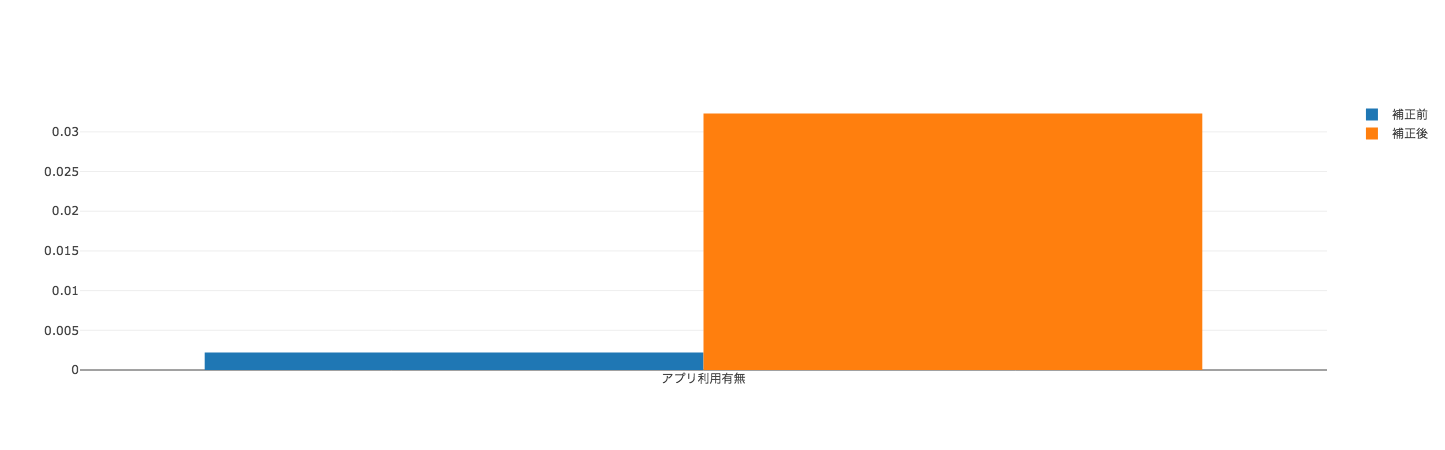

In [15]:
bar11 = Bar(x=["アプリ利用有無"], 
            y=[np.mean(df[df.cm_dummy == 1].gamedummy.values) - np.mean(df[df.cm_dummy == 0].gamedummy.values)],
            name="補正前")
bar12 = Bar(x=["アプリ利用有無"], y=[ate1],
            name="補正後")
fig1 = Figure(data=[bar11, bar12], layout=Layout(barmode="group"))
iplot(fig1)

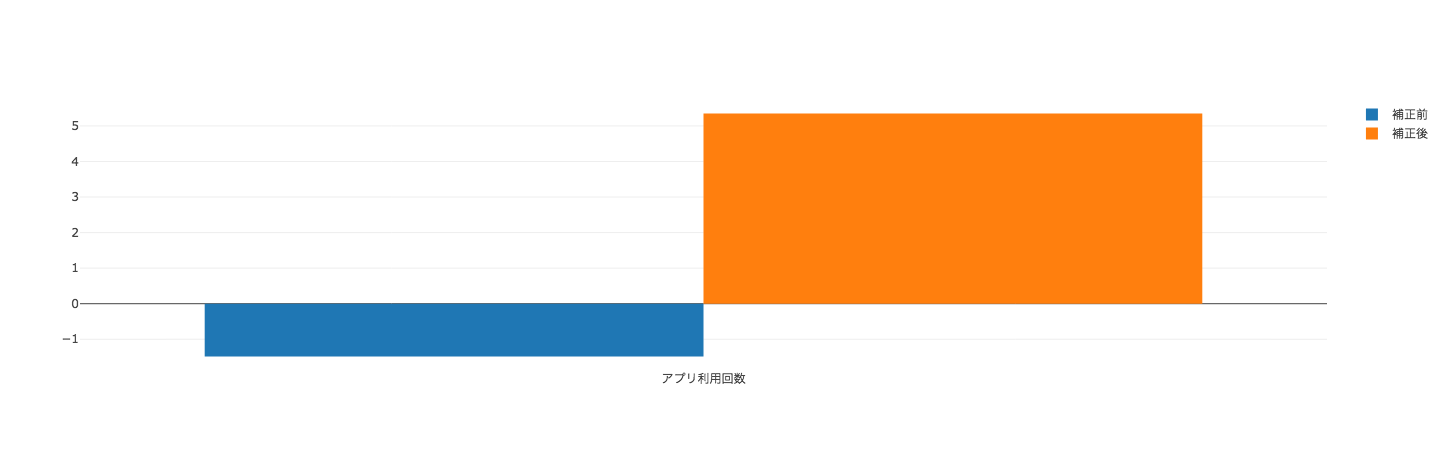

In [16]:
bar21 = Bar(x=["アプリ利用回数"], 
            y=[np.mean(df[df.cm_dummy == 1].gamecount.values) - np.mean(df[df.cm_dummy == 0].gamecount.values)],
            name="補正前")
bar22 = Bar(x=["アプリ利用回数"], y=[ate2],
            name="補正後")
fig2 = Figure(data=[bar21, bar22], layout=Layout(barmode="group"))
iplot(fig2)

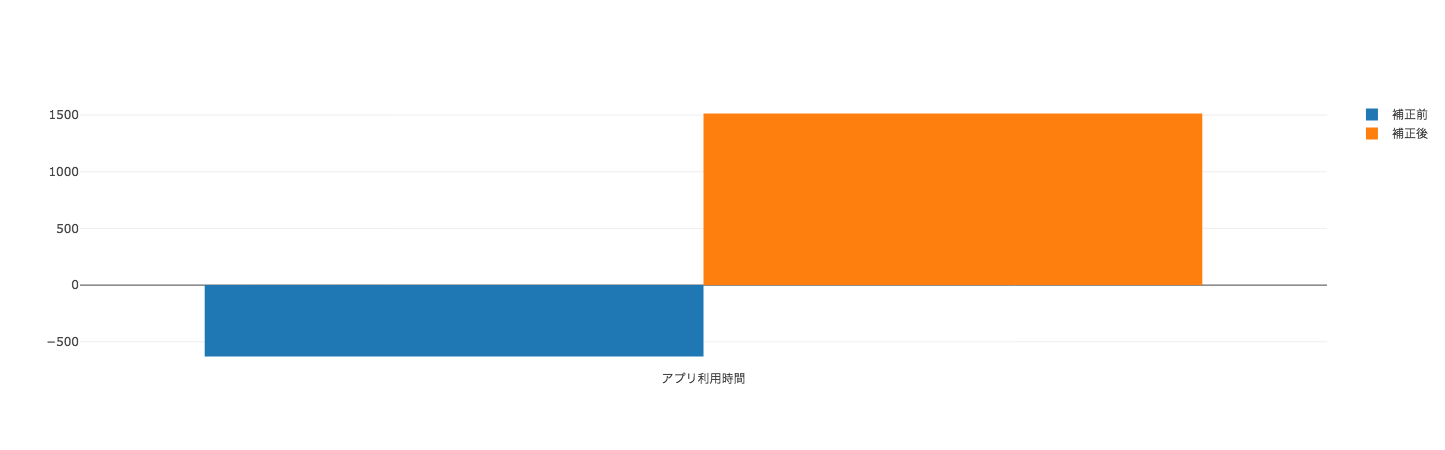

In [17]:
bar31 = Bar(x=["アプリ利用時間"], 
            y=[np.mean(df[df.cm_dummy == 1].gamesecond.values) - np.mean(df[df.cm_dummy == 0].gamesecond.values)],
            name="補正前")
bar32 = Bar(x=["アプリ利用時間"], y=[ate3],
            name="補正後")
fig3 = Figure(data=[bar31, bar32], layout=Layout(barmode="group"))
iplot(fig3)